# Вариант 7. Oт окружности грудной клетки в покое, роста, времени 10 хлопков; prevalence.

Классифицировать пол студента в зависимости от трех признаков
в соответствии с вариантом:

Выбрать строки из файла Volgmed_2013.xls, 
содержащие пол студента и три признака в соответствии с вариантом.

Стандартизовать признаки.


Всю выборку разбить случайным образом на обучающую (80%) и тестовую (20%) части.


По обучающей части обучить классификатор, основанный на методе 
опорных векторов с линейным ядром, условившись считать девушек 
положительным классом, а юношей отрицательным.

Применить обученный классификатор к тестовой части выборки.

Вывести диаграммы рассеяния в исходных (нестандартизованных) координатах, 
покрасив неверно классифицированные точки в разные цвета в зависимости от класса.

Вывести число истинно отрицательных (TN), ложно положительных (FP), 
ложно отрицательных (FN), истинно положительных (TP) точек тестовой части.

Вычислить сбалансированную точность (balanced accuracy), 
F1, а также статистику в соответствии 
с вариантом, переведя ее название на русский язык.

In [1]:
from pathlib import Path
from itertools import combinations

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
FILENAME = "Volgmed_2013.xlsx"
COLUMNS = ["Пол", "Окружность грудной клетки в покое, см", "Рост, см", "Время 10 хлопков, с"]

filepath = Path(FILENAME)
df = pd.read_excel(filepath, index_col=0, header=1)

df

,Пол,Год рождения,Факультет,Курс,Группа,Год поступления,Дата обследования,"Рост, см","Вес, кг","Окружность грудной клетки в покое, см",...,"Гибкость, см","Время 10 хлопков, с","Прыжок в длину с места, см","Челночный бег, с","Силовой норматив, ед","Бег 100 м, с","Бег 2-3 км, мин","Статическая выносливость, с","Задержка дыхания, с","Равновесие, с"
№ п/п,,,,,,,,,,,,,,,,,,,,,
104.0,жен,1981.0,лечебный,1.0,NaN,1999,2000-05-01,176,74.5,90,...,22,6.6,155,26,38,17.7,8.7,140,59.0,90.0
104.0,жен,1981.0,лечебный,3.0,NaN,1999,2002-05-01,176,74,90,...,23,6.5,158,25,47,18.7,6.58,144,68.0,90.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-05-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-05-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-05-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data = df[COLUMNS].copy()
data.rename(
    {
        "Пол": "sex", 
        "Окружность грудной клетки в покое, см": "chest_circumference_cm", 
        "Рост, см": "height_cm", 
        "Время 10 хлопков, с": "claps_time_s",
    },
    axis=1,
    inplace=True
)

data['chest_circumference_cm'] = pd.to_numeric(data['chest_circumference_cm'], errors='coerce')
data['height_cm'] = pd.to_numeric(data['height_cm'], errors='coerce')
data["claps_time_s"] = pd.to_numeric(data["claps_time_s"], errors='coerce')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

data.sex = data.sex.replace({'жен.': 1, 'жен': 1, 'муж.': 0, 'муж': 0})

data

C:\Users\vladk\AppData\Local\Temp\ipykernel_17796\47146271.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.sex = data.sex.replace({'жен.': 1, 'жен': 1, 'муж.': 0, 'муж': 0})


,sex,chest_circumference_cm,height_cm,claps_time_s
0,1,90.0,176.0,6.6
1,1,90.0,176.0,6.5
2,1,85.0,166.0,6.8
3,1,85.0,166.0,6.8
4,1,85.0,166.0,6.6
...,...,...,...,...
2282,0,89.0,167.0,5.4
2283,0,88.0,183.5,5.4
2284,0,91.0,171.0,5.1
2285,0,90.0,178.5,5.1


In [4]:
X = data[["chest_circumference_cm", "height_cm", "claps_time_s",]]
y = data.sex

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prevalence = (tp + fn) / (tp + tn + fp + fn)

print(f'Истинно отрицательные (TN): {tn}')
print(f'Ложно положительные (FP): {fp}')
print(f'Ложно отрицательные (FN): {fn}')
print(f'Истинно положительные (TP): {tp}')
print(f'Сбалансированная точность: {balanced_accuracy:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Распространенность (Prevalence): {prevalence:.2f}')

Истинно отрицательные (TN): 107
Ложно положительные (FP): 9
Ложно отрицательные (FN): 16
Истинно положительные (TP): 326
Сбалансированная точность: 0.94
F1-Score: 0.96
Распространенность (Prevalence): 0.75


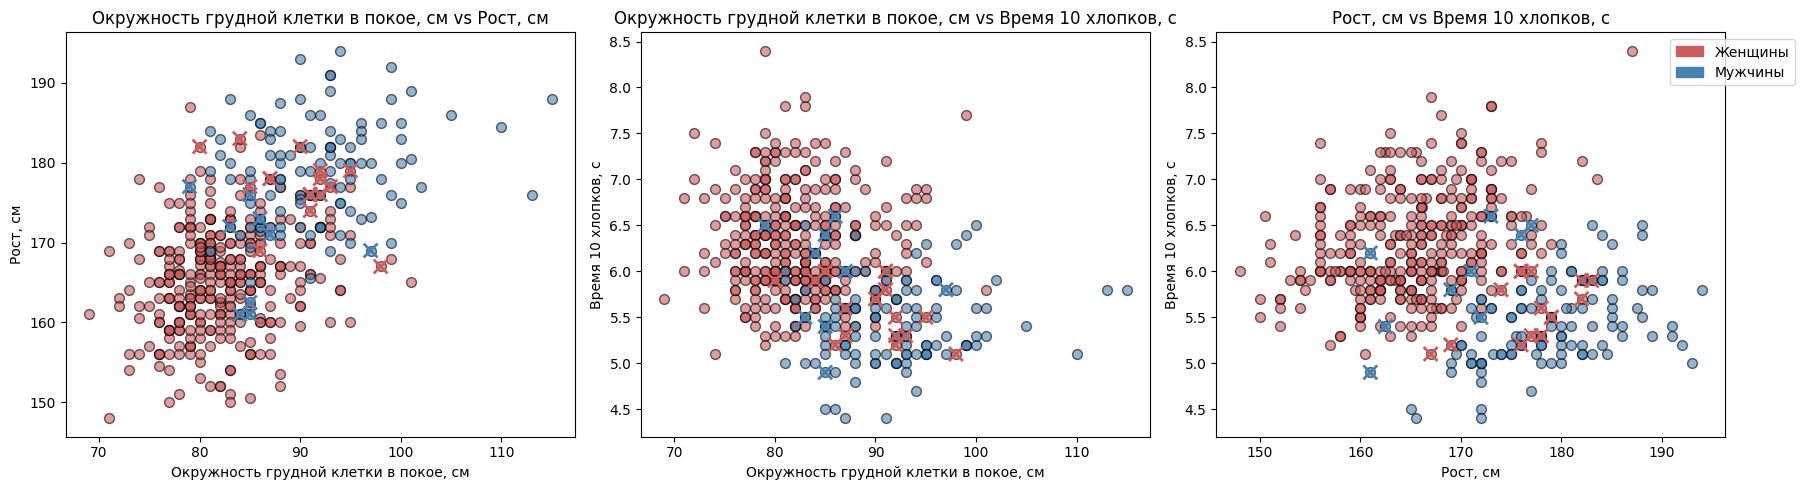

In [6]:
feature_names = ["Окружность грудной клетки в покое, см", "Рост, см", "Время 10 хлопков, с"]
pairs = list(combinations(range(3), 2))

X_unscaled = scaler.inverse_transform(X_test)

# Нахождение неверно классифицированных точек
misclassified = (y_test != y_pred)
misclassified_data = X_unscaled[misclassified]
misclassified_labels = y_test[misclassified]

# Определение цветов для классов
color_map = {1: 'indianred', 0: 'steelblue'}
class_labels = {1: 'Женщины', 0: 'Мужчины'}

# Создание фигур и диаграмм для каждой пары признаков
plt.figure(figsize=(18, 5))

for i, (x_idx, y_idx) in enumerate(pairs, start=1):
    plt.subplot(1, 3, i)
    
    # Диаграмма рассеяния для корректных и неверных классификаций
    for label, color in color_map.items():
        idx = (y_test == label)
        plt.scatter(X_unscaled[idx, x_idx], X_unscaled[idx, y_idx], 
                    color=color, edgecolor='black', s=50, alpha=0.6, 
                    label=f'{class_labels[label]} (корректно)')
        
    plt.scatter(misclassified_data[:, x_idx], misclassified_data[:, y_idx], 
                c=misclassified_labels.map(color_map), 
                marker='x', s=100, linewidths=2, label='Неверно классифицированные')
    
    plt.xlabel(feature_names[x_idx])
    plt.ylabel(feature_names[y_idx])
    plt.title(f'{feature_names[x_idx]} vs {feature_names[y_idx]}')

# Создание легенды для пола вне графиков
correct_patch_w = mpatches.Patch(color=color_map[1], label='Женщины')
correct_patch_m = mpatches.Patch(color=color_map[0], label='Мужчины')
plt.legend(handles=[correct_patch_w, correct_patch_m], loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()